In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import math

<Figure size 432x288 with 0 Axes>

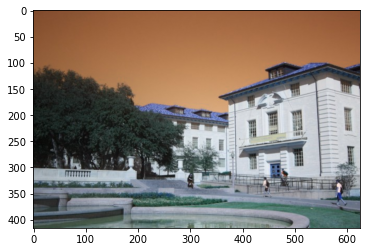

<Figure size 432x288 with 0 Axes>

In [2]:
#'right image' is read and screen printed
sagGoruntu=cv2.imread("right.jpeg")
plt.imshow(sagGoruntu)
plt.figure()


<Figure size 432x288 with 0 Axes>

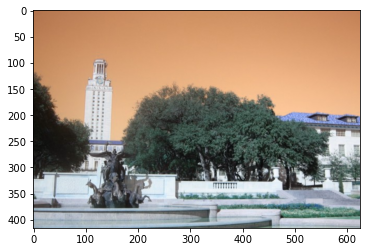

<Figure size 432x288 with 0 Axes>

In [3]:
#'left image' is read and screen printed
solGoruntu=cv2.imread("left.jpeg")
plt.imshow(solGoruntu)
plt.figure()

In [4]:
sagGoruntu01= cv2.cvtColor(sagGoruntu,cv2.COLOR_BGR2GRAY)
solGoruntu01= cv2.cvtColor(solGoruntu,cv2.COLOR_BGR2GRAY)

#Key points and descriptors were found. SIFT algorithm was used.
sift = cv2.xfeatures2d.SIFT_create()
anahtarNokta01, tanimlayici01 = sift.detectAndCompute(sagGoruntu,None)
anahtarNokta02, tanimlayici02 = sift.detectAndCompute(solGoruntu,None)

#Found key points and descriptors displayed on the right image
drawKeypoints=cv2.drawKeypoints(sagGoruntu,anahtarNokta01,None)
cv2.imshow('Draw Key Points',drawKeypoints)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
#Found key points and descriptors displayed on the left image
drawKeypoints02=cv2.drawKeypoints(solGoruntu,anahtarNokta02,None)
cv2.imshow('Draw Key Points',drawKeypoints02)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [6]:
# The distance between each descriptors in one image and each descriptors in another image was calculated.
eslesme = cv2.BFMatcher()
eslesmeler = eslesme.knnMatch(tanimlayici01 ,tanimlayici02,k=2)

#Matches that are less than a threshold could be chosen as the best matches.
enIyiEslesme = []
for m,n in eslesmeler:
    if m.distance < 0.27*n.distance:
        enIyiEslesme.append(m)


#It is the image that shows the key points that best match. The best matches are combined with the red lines.
cizim = dict(matchColor = (0,0,255), 
                   singlePointColor = None,
                   flags = 2)
eslestirilmis = cv2.drawMatches(sagGoruntu,anahtarNokta01,solGoruntu,anahtarNokta02,enIyiEslesme,None,**cizim)
cv2.imshow('Draw Matches',eslestirilmis)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [7]:
#Calculating the Homography matrix
def homographyHesapla(a):
    #loop through correspondences and create assemble matrix
    aList = []
    for corr in a:
        cd1 = np.matrix([corr.item(0), corr.item(1), 1])
        cd2 = np.matrix([corr.item(2), corr.item(3), 1])

        a2 = [0, 0, 0, -cd2.item(2) * cd1.item(0), -cd2.item(2) * cd1.item(1), -cd2.item(2) * cd1.item(2),
              cd2.item(1) * cd1.item(0), cd2.item(1) * cd1.item(1), cd2.item(1) * cd1.item(2)]
        a1 = [-cd2.item(2) * cd1.item(0), -cd2.item(2) * cd1.item(1), -cd2.item(2) * cd1.item(2), 0, 0, 0,
              cd2.item(0) * cd1.item(0), cd2.item(0) * cd1.item(1), cd2.item(0) * cd1.item(2)]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.matrix(aList)

    #singular value decomposition
    u, s, v = np.linalg.svd(matrixA)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))

    #normalize and now we have h
    h = (1/h.item(8)) * h
    return h

In [8]:
#calculate the geometric distance between estimated points andoriginal points
def uzaklik(b, h):

    cd1 = np.transpose(np.matrix([b[0].item(0), b[0].item(1), 1]))
    tahmincd2 = np.dot(h, cd1)
    tahmincd2 = (1/tahmincd2.item(2))*tahmincd2

    cd2 = np.transpose(np.matrix([b[0].item(2), b[0].item(3), 1]))
    error = cd2 - tahmincd2
    return np.linalg.norm(error)

In [9]:
#functions to plot inlier points with red dots
def noktalar(sagGoruntu,solGoruntu,inliers):

    satir_01 = sagGoruntu.shape[0]
    sutun_01 = sagGoruntu.shape[1]
    satir_02 = solGoruntu.shape[0]
    sutun_02 = solGoruntu.shape[1]

    cikti = np.zeros((max([satir_01,satir_02]),sutun_01+sutun_02,3), dtype='uint8')

    # Place the first image to the left
    cikti[:satir_01,:sutun_01,:] = np.dstack([sagGoruntu01, sagGoruntu01, sagGoruntu01])

    # Place the next image to the right of it
    cikti[:satir_02,sutun_01:sutun_01+sutun_02,:] = np.dstack([solGoruntu01, solGoruntu01, solGoruntu01])
    
    for i in inliers:
            x1 = i.item(0)
            y1 = i.item(1)
            x2 = i.item(2)
            y2 = i.item(3)
            
            cv2.circle(cikti, (int(x1),int(y1)), 4, (255, 0, 0), 1)
            cv2.circle(cikti, (int(x2)+sutun_01,int(y2)), 4, (255, 0, 0), 1)
    plt.imshow(cikti)
    plt.show()

In [10]:
def ortalamaKalinti(inliers):
    sum=0
    for i in inliers:
        x1 = i.item(0)
        y1 = i.item(1)
        x2 = i.item(2)
        y2 = i.item(3)
        sum += math.sqrt(((x1-x2)**2) + ((y1-y2)**2))
    avg = sum/(float)(len(inliers))
    print("The average residuals for inliers is:",avg,end=" ")
    print()

In [11]:
#RANSAC algorithm which creates homographies from random correspondences 
def RANSACalgorithm(corr, thresh,sagGoruntu,solGoruntu):
    maxInliers = []
    finalH = None
    for i in range(1000):
        #find 4 random points to calculate a homography
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        rastgele4Nokta = np.vstack((corr1, corr2))
        corr3 = corr[random.randrange(0, len(corr))]
        rastgele4Nokta = np.vstack((rastgele4Nokta, corr3))
        corr4 = corr[random.randrange(0, len(corr))]
        rastgele4Nokta = np.vstack((rastgele4Nokta, corr4))

        #call the homography function on those points
        h = homographyHesapla(rastgele4Nokta)
        inliers = []
        
        #calling geometric distance function
        for i in range(len(corr)):
            d = uzaklik(corr[i], h)
            if d < 5:
                inliers.append(corr[i])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
        print("Corr size: ", len(corr), " NumInliers: ", len(inliers), "Max inliers: ", len(maxInliers))

        if len(maxInliers) > (len(corr)*thresh):
            break

    noktalar(sagGoruntu,solGoruntu,maxInliers)
    ortalamaKalinti(maxInliers)
    return finalH, maxInliers

Corr size:  77  NumInliers:  74 Max inliers:  74


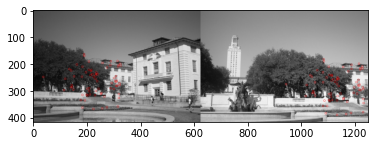

The average residuals for inliers is: 278.3522609472895 


In [12]:
#Finding Homography marix 
MIN_MATCH_COUNT = 10
cList=[]
if len(enIyiEslesme) > MIN_MATCH_COUNT:
    
    for m in enIyiEslesme:
        (x1,y1) = anahtarNokta01[m.queryIdx].pt
        (x2,y2) = anahtarNokta02[m.trainIdx].pt
        cList.append([x1,y1,x2,y2])
    corrs = np.matrix(cList)
    M,inliers = RANSACalgorithm(corrs,0.6,sagGoruntu,solGoruntu)
    h,w = sagGoruntu01.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img5 = cv2.polylines(solGoruntu01,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    
else:
    print ("Not enough matches are found - %d/%d" % (len(enIyiEslesme),MIN_MATCH_COUNT))

In [13]:
#The right image is taken as a reference and converting to the other image to match the right image (warping) has been applied.
dst = cv2.warpPerspective(sagGoruntu,M,(solGoruntu.shape[1] + sagGoruntu.shape[1], solGoruntu.shape[0]))
dst[0:solGoruntu.shape[0], 0:solGoruntu.shape[1]] = solGoruntu

In [14]:
#Dark side of the image is removed here after stitching
def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop bottom
    elif not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop left
    elif not np.sum(frame[:,0]):
        return trim(frame[:,1:]) 
    #crop right
    elif not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])    
    return frame

In [15]:
t=trim(dst)
cv2.imshow('Stiched',t)
cv2.waitKey(0)
cv2.destroyAllWindows()